In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import os
from skimage import io, transform
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
from skimage.io import imread
from torchsummary import summary
import pandas as pd
import time

TRAIN_ROOT = 'data/Train'
VAL_ROOT = 'data/Validation'
BATCH_SIZE = 32
EPOCHS = 4
LOG_INTERVAL = 50
BOTTLENECK_SIZE = 512
SAVE_MODEL = 'model_KL5z_off'
SAVE_IMGS = 'results_KL5z_off'

In [2]:
no_cuda = False
seed = 1
cuda = not no_cuda and torch.cuda.is_available()
torch.manual_seed(seed)
device = torch.device("cuda" if cuda else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
torch.manual_seed(seed)


transform_seq = [ transforms.Resize((200,163)), transforms.Pad(( 19, 0, 18, 0)),
                  transforms.ToTensor(), transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))]

train_loader_celeba = torch.utils.data.DataLoader(
    datasets.ImageFolder(TRAIN_ROOT, transform=transforms.Compose(transform_seq)),
    batch_size = BATCH_SIZE, shuffle=True, **kwargs)

val_loader_celeba = torch.utils.data.DataLoader(
    datasets.ImageFolder(VAL_ROOT, transform=transforms.Compose(transform_seq)),
    batch_size = BATCH_SIZE, shuffle=True, **kwargs)

In [3]:
data =  datasets.ImageFolder(TRAIN_ROOT, transform=transforms.Compose(transform_seq))

In [4]:
data

Dataset ImageFolder
    Number of datapoints: 159999
    Root location: data/Train
    StandardTransform
Transform: Compose(
               Resize(size=(200, 163), interpolation=PIL.Image.BILINEAR)
               Pad(padding=(19, 0, 18, 0), fill=0, padding_mode=constant)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [5]:
PAD = 1
PAD_MXP = 0
PAD_TRANSP = 0
BIAS = True
PRINT_SIZE = False 

class VAE_CNN(nn.Module):
    def __init__(self):
        super(VAE_CNN, self).__init__()

        # Encoder
        self.conv1 = nn.Conv2d(3, 32, kernel_size=(3,3), stride=1, padding=(1,1), bias=BIAS)
        self.bn1 = nn.BatchNorm2d(32)
        self.mxp1 = nn.MaxPool2d(2, padding=PAD_MXP)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=(3,3), stride=1, padding=PAD, bias=BIAS)
        self.bn2 = nn.BatchNorm2d(64)
        self.mxp2 = nn.MaxPool2d(2, padding=PAD_MXP)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=(3,3), stride=1, padding=PAD, bias=BIAS)
        self.bn3 = nn.BatchNorm2d(128)
        self.mxp3 = nn.MaxPool2d(2, padding=PAD_MXP)

        self.conv4 = nn.Conv2d(128, 256, kernel_size=(3,3), stride=1, padding=PAD, bias=BIAS)
        self.bn4 = nn.BatchNorm2d(256)
        self.mxp4 = nn.MaxPool2d(2, padding=1)

        # Latent vectors mu and sigma
        self.fc1 = nn.Linear(13*13*256, BOTTLENECK_SIZE)
        self.fc_bn1 = nn.BatchNorm1d(BOTTLENECK_SIZE)
        
        self.fc2 = nn.Linear(BOTTLENECK_SIZE, BOTTLENECK_SIZE)
        self.fc_bn2 = nn.BatchNorm1d(BOTTLENECK_SIZE)
        
        # Sampling vector
        self.fc3 = nn.Linear(BOTTLENECK_SIZE, 13*13*256)
        self.fc_bn3 = nn.BatchNorm1d(13*13*256)
        
        # Decoder
        self.ups5 = nn.Upsample(scale_factor = 2) 
        self.conv5 = nn.ConvTranspose2d(256, 256, kernel_size=3, stride=1, padding=PAD, bias=BIAS)
        self.bn5 = nn.BatchNorm2d(256)
        
        self.ups6 = nn.Upsample(scale_factor = 2) 
        self.conv6 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=1, padding=PAD, bias=BIAS)
        self.bn6 = nn.BatchNorm2d(128)
        
        self.ups7 = nn.Upsample(scale_factor = 2) 
        self.conv7 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=PAD, bias=BIAS)
        self.bn7 = nn.BatchNorm2d(64)
        
        self.ups8 = nn.Upsample(scale_factor = 2) 
        self.conv8 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=1, padding=PAD, bias=BIAS)
        self.bn8 = nn.BatchNorm2d(32)
        
        
        self.conv9 = nn.ConvTranspose2d(32, 3, kernel_size=3, stride=1, padding=1, bias=BIAS)
        

        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()

    def encode(self, x):
        conv1 = self.mxp1(self.relu(self.bn1(self.conv1(x))))
        conv2 = self.mxp2(self.relu(self.bn2(self.conv2(conv1))))
        conv3 = self.mxp3(self.relu(self.bn3(self.conv3(conv2))))
        conv4 = self.mxp4(self.relu(self.bn4(self.conv4(conv3))))
        conv4 = conv4.view(-1, 13 * 13 * 256)

        fc1 = self.fc_bn1(self.fc_bn1(self.fc1(conv4)))
        fc2 = self.fc_bn2(self.fc_bn1(self.fc2(fc1))) 
        
        '''
        print(conv1.size())
        print(conv2.size())
        print(conv3.size())
        print(conv4.size())
        print(conv4.size())
        print(fc1.size())
        print(fc2.size())
        '''
        return fc1, fc2

    def reparameterize(self, mu, logvar):
        '''        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = Variable(std.data.new(std.size()).normal_())
            return eps.mul(std).add_(mu)
        else:
            return mu
        '''
        std = logvar.mul(0.5).exp_()
        eps = Variable(std.data.new(std.size()).normal_())
        return eps.mul(std).add_(mu)

        
    def decode(self, z):
        fc3 = self.relu(self.fc_bn3(self.fc3(z)))
        fc3 = fc3.view(-1, 256, 13,13)
        
        conv5 = self.relu(self.bn5(self.conv5(self.ups5(fc3))))
        conv6 = self.relu(self.bn6(self.conv6(self.ups6(conv5))))
        conv6 = conv6.narrow(3, 0, 51)
        conv6 = conv6.narrow(2, 0, 51)
        conv7 = self.relu(self.bn7(self.conv7(self.ups7(conv6))))
        conv7 = conv7.narrow(3, 0, 100)
        conv7 = conv7.narrow(2, 0, 100)    
        conv8 = self.relu(self.bn8(self.conv8(self.ups8(conv7))))
        conv9 = self.tanh(self.conv9(conv8))

        '''
        print(fc3.size())
        print(fc3.size())
        print(conv5.size())
        print(conv6.size())
        print(conv7.size())
        print(conv8.size())
        print(conv9.size())'''
        
        return conv9

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [6]:
class customLoss(nn.Module):
    def __init__(self):
        super(customLoss, self).__init__()
        self.mse_loss = nn.MSELoss(reduction="mean")

    def forward(self, x_recon, x, mu, logvar):
        loss_MSE = self.mse_loss(x_recon, x)
        loss_KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

        return loss_MSE, 0.000001 * loss_KLD

In [7]:
model = VAE_CNN().to(device)
optimizer = optim.RMSprop(model.parameters(), lr=0.001, alpha= 0.9)
loss_custom = customLoss()

In [8]:
#summary(model, (3,200,200))

In [9]:
'''model.train()
train_loss = 0

data = batch.to(device)
optimizer.zero_grad()
recon_batch, mu, logvar = model(data)
loss = loss_mse(recon_batch, data, mu, logvar)
loss.backward()
train_loss += loss.item()
optimizer.step()
'''

'model.train()\ntrain_loss = 0\n\ndata = batch.to(device)\noptimizer.zero_grad()\nrecon_batch, mu, logvar = model(data)\nloss = loss_mse(recon_batch, data, mu, logvar)\nloss.backward()\ntrain_loss += loss.item()\noptimizer.step()\n'

In [10]:
val_losses = []
train_losses = []

def train(epoch):
    epoch_start = 0
    model.train()
    train_loss = 0
    start = time.time()
    for batch_idx, (data, _) in enumerate(train_loader_celeba): 
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss_mse, loss_kl = loss_custom(recon_batch, data, mu, logvar)
        loss = loss_mse + loss_kl
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % LOG_INTERVAL == 0:
            interval = time.time() - start
            start = time.time()
            epoch_start = epoch_start + interval
            
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss MSE: {:.6f} \tLoss KL: {:.6f} \tTime Interv: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader_celeba.dataset),
                       100. * batch_idx / len(train_loader_celeba),
                       loss_mse.item() / len(data), loss_kl.item() / len(data), interval))

    print('====> Epoch: {} Average loss: {:.4f} Elapsed Time: {:.6f}'.format(
        epoch, train_loss / len(train_loader_celeba.dataset), epoch_start))
    train_losses.append(train_loss / len(train_loader_celeba.dataset))


In [11]:
def test(epoch, sufix, train):
    model.train(train)
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(val_loader_celeba):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            loss_mse, loss_kl = loss_custom(recon_batch, data, mu, logvar)
            loss = loss_mse + loss_kl
            test_loss += loss.item()
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n],
                                        recon_batch.view(7, 3, 200, 200)[:n]])
                save_image(comparison.cpu(),
                           'results/reconstruction_' + str(epoch) + sufix + '.png', nrow=n, normalize=True)

    test_loss /= len(val_loader_celeba.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))
    val_losses.append(test_loss)

In [12]:
for epoch in range(1, EPOCHS + 1):
    train(epoch)
    test(epoch, '_on', True)
    test(epoch, '_off', False)
    with torch.no_grad():
        sample = torch.randn(BATCH_SIZE, BOTTLENECK_SIZE).to(device)
        sample = model.decode(sample).cpu()
        save_image(sample.view(BATCH_SIZE, 3, 200, 200),
                   'results/sample_' + str(epoch) + '.png', normalize=True)

Train Epoch: 1 [0/159999 (0%)]	Loss MSE: 0.029105 	Loss KL: 0.000419 	Time Interv: 2.433342
Train Epoch: 1 [1600/159999 (1%)]	Loss MSE: 0.004533 	Loss KL: 0.000403 	Time Interv: 14.300820
Train Epoch: 1 [3200/159999 (2%)]	Loss MSE: 0.002922 	Loss KL: 0.000379 	Time Interv: 14.837749


KeyboardInterrupt: 

In [10]:
for epoch in range(1, EPOCHS + 1):
    train(epoch)
    test(epoch, '_on', True)
    test(epoch, '_off', False)
    with torch.no_grad():
        sample = torch.randn(BATCH_SIZE, BOTTLENECK_SIZE).to(device)
        sample = model.decode(sample).cpu()
        save_image(sample.view(BATCH_SIZE, 3, 200, 200),
                   'results/sample_' + str(epoch) + '.png', normalize=True)

Train Epoch: 1 [0/202599 (0%)]	Loss MSE: 0.030853 	Loss KL: 0.000420 	Time Interv: 2.245604
Train Epoch: 1 [1600/202599 (1%)]	Loss MSE: 0.004019 	Loss KL: 0.000398 	Time Interv: 10.193710
Train Epoch: 1 [3200/202599 (2%)]	Loss MSE: 0.003228 	Loss KL: 0.000375 	Time Interv: 10.234328
Train Epoch: 1 [4800/202599 (2%)]	Loss MSE: 0.002614 	Loss KL: 0.000356 	Time Interv: 10.184023
Train Epoch: 1 [6400/202599 (3%)]	Loss MSE: 0.002484 	Loss KL: 0.000340 	Time Interv: 10.193042
Train Epoch: 1 [8000/202599 (4%)]	Loss MSE: 0.002583 	Loss KL: 0.000331 	Time Interv: 10.138095
Train Epoch: 1 [9600/202599 (5%)]	Loss MSE: 0.002463 	Loss KL: 0.000323 	Time Interv: 10.273180
Train Epoch: 1 [11200/202599 (6%)]	Loss MSE: 0.001968 	Loss KL: 0.000312 	Time Interv: 10.139698
Train Epoch: 1 [12800/202599 (6%)]	Loss MSE: 0.002153 	Loss KL: 0.000308 	Time Interv: 10.208818
Train Epoch: 1 [14400/202599 (7%)]	Loss MSE: 0.002072 	Loss KL: 0.000302 	Time Interv: 10.186907
Train Epoch: 1 [16000/202599 (8%)]	Loss M

Train Epoch: 1 [134400/202599 (66%)]	Loss MSE: 0.001031 	Loss KL: 0.000300 	Time Interv: 10.181094
Train Epoch: 1 [136000/202599 (67%)]	Loss MSE: 0.001044 	Loss KL: 0.000300 	Time Interv: 10.147753
Train Epoch: 1 [137600/202599 (68%)]	Loss MSE: 0.001087 	Loss KL: 0.000300 	Time Interv: 10.277654
Train Epoch: 1 [139200/202599 (69%)]	Loss MSE: 0.001291 	Loss KL: 0.000300 	Time Interv: 9.970698
Train Epoch: 1 [140800/202599 (69%)]	Loss MSE: 0.001241 	Loss KL: 0.000300 	Time Interv: 10.097426
Train Epoch: 1 [142400/202599 (70%)]	Loss MSE: 0.001044 	Loss KL: 0.000300 	Time Interv: 10.158448
Train Epoch: 1 [144000/202599 (71%)]	Loss MSE: 0.001075 	Loss KL: 0.000301 	Time Interv: 10.159964
Train Epoch: 1 [145600/202599 (72%)]	Loss MSE: 0.001160 	Loss KL: 0.000301 	Time Interv: 10.142982
Train Epoch: 1 [147200/202599 (73%)]	Loss MSE: 0.001169 	Loss KL: 0.000301 	Time Interv: 10.078451
Train Epoch: 1 [148800/202599 (73%)]	Loss MSE: 0.001140 	Loss KL: 0.000301 	Time Interv: 10.215870
Train Epoch

Train Epoch: 2 [64000/202599 (32%)]	Loss MSE: 0.000808 	Loss KL: 0.000305 	Time Interv: 10.131733
Train Epoch: 2 [65600/202599 (32%)]	Loss MSE: 0.001026 	Loss KL: 0.000306 	Time Interv: 10.074945
Train Epoch: 2 [67200/202599 (33%)]	Loss MSE: 0.000937 	Loss KL: 0.000306 	Time Interv: 10.258358
Train Epoch: 2 [68800/202599 (34%)]	Loss MSE: 0.000957 	Loss KL: 0.000306 	Time Interv: 10.211416
Train Epoch: 2 [70400/202599 (35%)]	Loss MSE: 0.001238 	Loss KL: 0.000306 	Time Interv: 10.283541
Train Epoch: 2 [72000/202599 (36%)]	Loss MSE: 0.000974 	Loss KL: 0.000306 	Time Interv: 10.259954
Train Epoch: 2 [73600/202599 (36%)]	Loss MSE: 0.000875 	Loss KL: 0.000306 	Time Interv: 10.104355
Train Epoch: 2 [75200/202599 (37%)]	Loss MSE: 0.000952 	Loss KL: 0.000306 	Time Interv: 10.087587
Train Epoch: 2 [76800/202599 (38%)]	Loss MSE: 0.001093 	Loss KL: 0.000306 	Time Interv: 10.273249
Train Epoch: 2 [78400/202599 (39%)]	Loss MSE: 0.001038 	Loss KL: 0.000307 	Time Interv: 10.189699
Train Epoch: 2 [8000

Train Epoch: 2 [196800/202599 (97%)]	Loss MSE: 0.000822 	Loss KL: 0.000308 	Time Interv: 10.194630
Train Epoch: 2 [198400/202599 (98%)]	Loss MSE: 0.000847 	Loss KL: 0.000308 	Time Interv: 10.193410
Train Epoch: 2 [200000/202599 (99%)]	Loss MSE: 0.000816 	Loss KL: 0.000308 	Time Interv: 10.145828
Train Epoch: 2 [201600/202599 (99%)]	Loss MSE: 0.000906 	Loss KL: 0.000308 	Time Interv: 10.083532
====> Epoch: 2 Average loss: 0.0012 Elapsed Time: 1284.082295
====> Test set loss: 0.0056
====> Test set loss: 0.0580
Train Epoch: 3 [0/202599 (0%)]	Loss MSE: 0.000895 	Loss KL: 0.000308 	Time Interv: 0.442984
Train Epoch: 3 [1600/202599 (1%)]	Loss MSE: 0.000818 	Loss KL: 0.000308 	Time Interv: 10.268776
Train Epoch: 3 [3200/202599 (2%)]	Loss MSE: 0.000875 	Loss KL: 0.000308 	Time Interv: 10.196753
Train Epoch: 3 [4800/202599 (2%)]	Loss MSE: 0.000920 	Loss KL: 0.000309 	Time Interv: 10.102145
Train Epoch: 3 [6400/202599 (3%)]	Loss MSE: 0.000784 	Loss KL: 0.000308 	Time Interv: 10.133227
Train Epoc

Train Epoch: 3 [126400/202599 (62%)]	Loss MSE: 0.000882 	Loss KL: 0.000308 	Time Interv: 10.271350
Train Epoch: 3 [128000/202599 (63%)]	Loss MSE: 0.000748 	Loss KL: 0.000308 	Time Interv: 10.309817
Train Epoch: 3 [129600/202599 (64%)]	Loss MSE: 0.000774 	Loss KL: 0.000308 	Time Interv: 10.193483
Train Epoch: 3 [131200/202599 (65%)]	Loss MSE: 0.000759 	Loss KL: 0.000308 	Time Interv: 10.273438
Train Epoch: 3 [132800/202599 (66%)]	Loss MSE: 0.000890 	Loss KL: 0.000308 	Time Interv: 10.145972
Train Epoch: 3 [134400/202599 (66%)]	Loss MSE: 0.000786 	Loss KL: 0.000308 	Time Interv: 10.206432
Train Epoch: 3 [136000/202599 (67%)]	Loss MSE: 0.000939 	Loss KL: 0.000308 	Time Interv: 10.094275
Train Epoch: 3 [137600/202599 (68%)]	Loss MSE: 0.000841 	Loss KL: 0.000308 	Time Interv: 10.079703
Train Epoch: 3 [139200/202599 (69%)]	Loss MSE: 0.000808 	Loss KL: 0.000308 	Time Interv: 10.168156
Train Epoch: 3 [140800/202599 (69%)]	Loss MSE: 0.000807 	Loss KL: 0.000308 	Time Interv: 10.201686
Train Epoc

Train Epoch: 4 [56000/202599 (28%)]	Loss MSE: 0.000731 	Loss KL: 0.000308 	Time Interv: 10.269035
Train Epoch: 4 [57600/202599 (28%)]	Loss MSE: 0.000796 	Loss KL: 0.000308 	Time Interv: 10.122923
Train Epoch: 4 [59200/202599 (29%)]	Loss MSE: 0.000786 	Loss KL: 0.000308 	Time Interv: 10.284022
Train Epoch: 4 [60800/202599 (30%)]	Loss MSE: 0.000817 	Loss KL: 0.000308 	Time Interv: 10.011788
Train Epoch: 4 [62400/202599 (31%)]	Loss MSE: 0.000833 	Loss KL: 0.000308 	Time Interv: 10.080644
Train Epoch: 4 [64000/202599 (32%)]	Loss MSE: 0.000822 	Loss KL: 0.000308 	Time Interv: 10.057491
Train Epoch: 4 [65600/202599 (32%)]	Loss MSE: 0.000794 	Loss KL: 0.000307 	Time Interv: 10.397938
Train Epoch: 4 [67200/202599 (33%)]	Loss MSE: 0.000669 	Loss KL: 0.000307 	Time Interv: 10.250497
Train Epoch: 4 [68800/202599 (34%)]	Loss MSE: 0.000832 	Loss KL: 0.000307 	Time Interv: 10.184501
Train Epoch: 4 [70400/202599 (35%)]	Loss MSE: 0.000758 	Loss KL: 0.000308 	Time Interv: 10.176241
Train Epoch: 4 [7200

Train Epoch: 4 [190400/202599 (94%)]	Loss MSE: 0.000757 	Loss KL: 0.000309 	Time Interv: 10.181417
Train Epoch: 4 [192000/202599 (95%)]	Loss MSE: 0.000693 	Loss KL: 0.000309 	Time Interv: 10.252429
Train Epoch: 4 [193600/202599 (96%)]	Loss MSE: 0.000878 	Loss KL: 0.000308 	Time Interv: 10.083488
Train Epoch: 4 [195200/202599 (96%)]	Loss MSE: 0.000754 	Loss KL: 0.000309 	Time Interv: 10.156882
Train Epoch: 4 [196800/202599 (97%)]	Loss MSE: 0.000745 	Loss KL: 0.000308 	Time Interv: 10.108484
Train Epoch: 4 [198400/202599 (98%)]	Loss MSE: 0.000766 	Loss KL: 0.000309 	Time Interv: 10.145343
Train Epoch: 4 [200000/202599 (99%)]	Loss MSE: 0.000991 	Loss KL: 0.000309 	Time Interv: 10.094003
Train Epoch: 4 [201600/202599 (99%)]	Loss MSE: 0.000869 	Loss KL: 0.000309 	Time Interv: 10.220209
====> Epoch: 4 Average loss: 0.0011 Elapsed Time: 1282.926998
====> Test set loss: 0.0051
====> Test set loss: 0.0619


In [12]:
torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, SAVE_FOLDER)

In [13]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

In [14]:
%matplotlib inline
def show(img):
    npimg = img.detach().numpy()
    plt.figure(figsize=(30, 10))
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

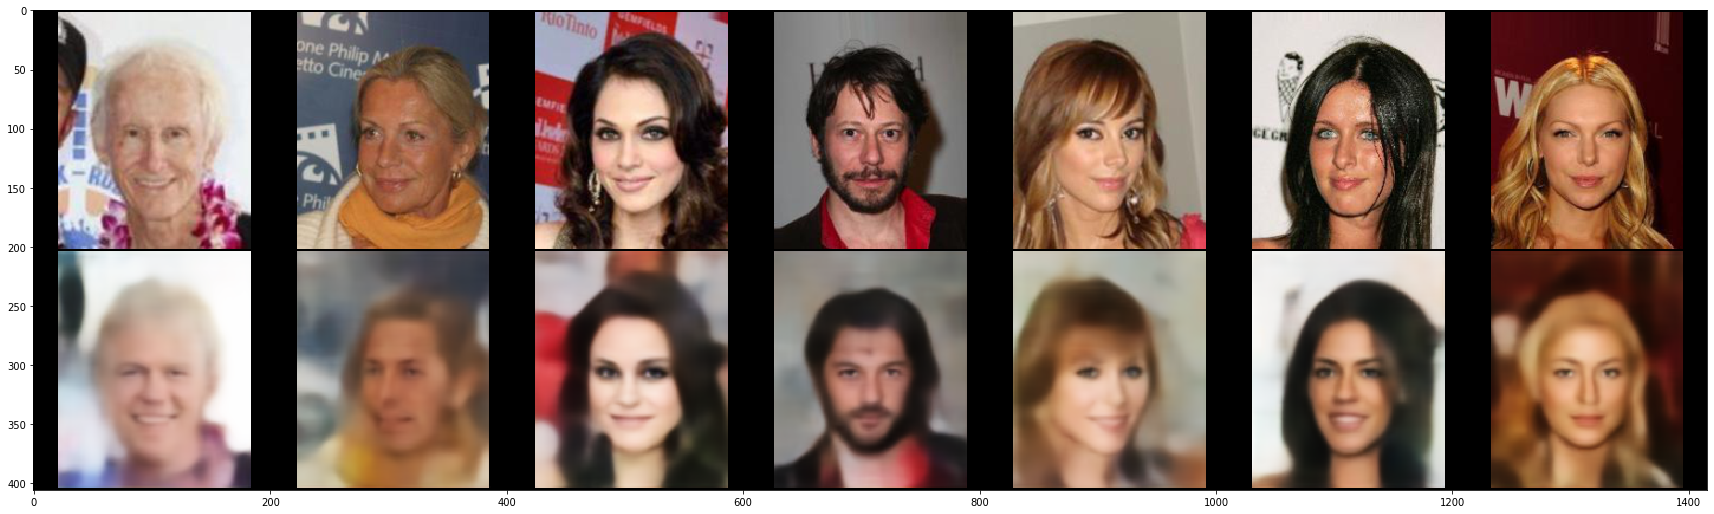

In [15]:
model.train(True)
test_loss = 0
for i, (data, _) in enumerate(val_loader_celeba):
    data = data.to(device)
    recon_batch, mu, logvar = model(data)
    loss_mse, loss_kl = loss_custom(recon_batch, data, mu, logvar)
    loss = loss_mse + loss_kl
    test_loss += loss.item()
    if i == 0:
        n = min(data.size(0), 8)
        comparison = torch.cat([data[:n],
                                recon_batch.view(7, 3, 200, 200)[:n]])
        show(make_grid(comparison.cpu(), nrow=n, normalize=True))

In [17]:
loss

tensor(0.1582, device='cuda:0', grad_fn=<AddBackward0>)

In [13]:
checkpoint = torch.load('model_save')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']



In [11]:
loss

tensor(0.0955, device='cuda:0', requires_grad=True)

In [13]:
model.train(True)
test_loss = 0
for i, (data, _) in enumerate(val_loader_celeba):
    data = data.to(device)
    recon_batch, mu, logvar = model(data)
    loss_mse, loss_kl = loss_custom(recon_batch, data, mu, logvar)
    loss = loss_mse + loss_kl
    test_loss += loss.item()
    if i == 0:
        n = min(data.size(0), 8)
        comparison = torch.cat([data[:n],
                                recon_batch.view(7, 3, 200, 200)[:n]])
        show(make_grid(comparison.cpu(), nrow=n, normalize=True))

NameError: name 'show' is not defined

TypeError: Invalid shape (3, 406, 1416) for image data

<Figure size 2160x720 with 0 Axes>

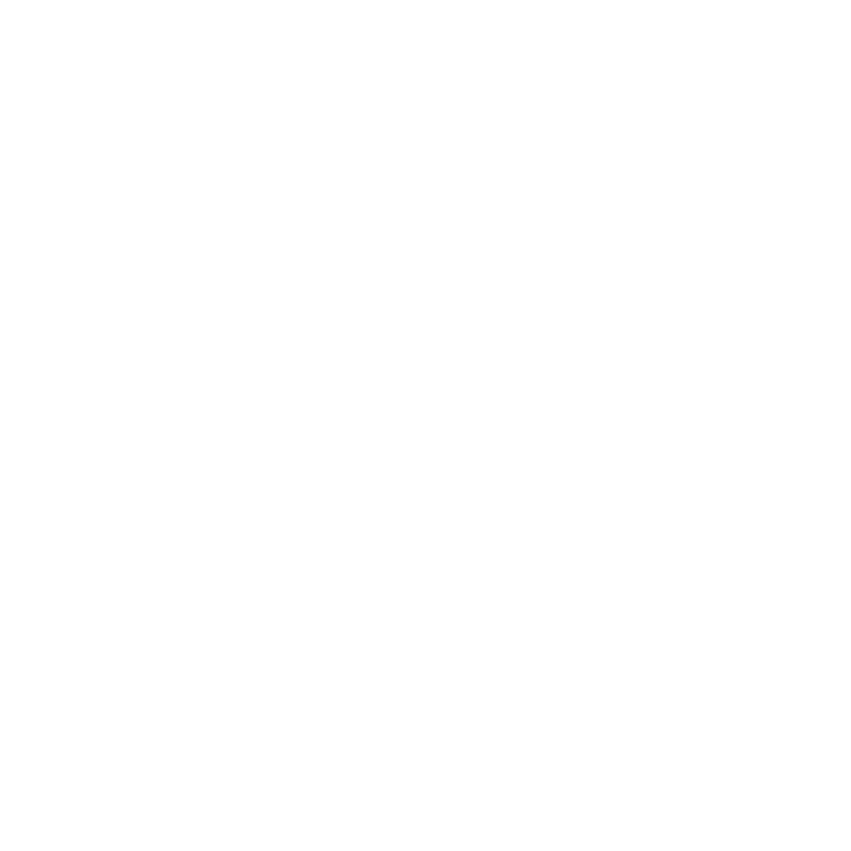

In [14]:
import random
x_test = []
plt.figure(figsize=(30,10))
num_figs = 1
plt.figure(figsize=(15,100))
plt.axis('off')
plt.imshow(make_grid(comparison.cpu(), nrow=n, normalize=True).detach().numpy())
'''
for i in range(num_figs):
    figure_Decoded = vae_2.predict(np.array([x_test[i].astype('float32')/127.5 -1]), batch_size = b_size)
    plt.axis('off')
    plt.subplot(num_figs,2,1+i*2)
    plt.imshow(x_test[i])
    plt.axis('off')
    plt.subplot(num_figs,2,2 + i*2)
    plt.imshow((figure_Decoded[0]+1)/2)
    plt.axis('off')
'''
plt.show()

In [12]:
torch.save({
            'epoch': 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss
            }, "model_save")

NameError: name 'loss' is not defined